In [1]:
import os
import shutil

# ===== PATH KONFIGURASI =====
SRC_IMAGES_DIR = r"C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\frames_iter"

DST_IMAGES_DIR = r"C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\5-iter\data_iter5 - Copy\images"
DST_LABELS_DIR = r"C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\5-iter\data_iter5 - Copy\labels"

# Ekstensi gambar yang dianggap valid
IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png")

# ===== PASTIKAN FOLDER TUJUAN ADA =====
os.makedirs(DST_IMAGES_DIR, exist_ok=True)
os.makedirs(DST_LABELS_DIR, exist_ok=True)

copied_count = 0
skipped_count = 0

for filename in os.listdir(SRC_IMAGES_DIR):
    if not filename.lower().endswith(IMAGE_EXTENSIONS):
        continue

    src_image_path = os.path.join(SRC_IMAGES_DIR, filename)
    dst_image_path = os.path.join(DST_IMAGES_DIR, filename)

    # Jika gambar sudah ada, abaikan
    if os.path.exists(dst_image_path):
        skipped_count += 1
        continue

    # Copy gambar
    shutil.copy2(src_image_path, dst_image_path)
    copied_count += 1

    # Buat file label kosong jika belum ada
    label_name = os.path.splitext(filename)[0] + ".txt"
    dst_label_path = os.path.join(DST_LABELS_DIR, label_name)

    if not os.path.exists(dst_label_path):
        open(dst_label_path, "w").close()

print("Proses selesai")
print(f"Gambar dicopy   : {copied_count}")
print(f"Gambar di-skip  : {skipped_count}")


Proses selesai
Gambar dicopy   : 377
Gambar di-skip  : 1911


In [8]:
import os
import math
import csv
import yaml
from ultralytics import YOLO

# =========================
# 1. KONFIGURASI PATH
# =========================
# Path ke data.yaml asli Anda
ORIGINAL_YAML = r"C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\test_est\data.yaml"
# Folder tempat gambar test berada
TEST_IMAGE_DIR = r"C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\test_est\test\images"
ROOT_DIR = r"C:/Users/USER/Documents/a skripsi/riset/history/10-ep-5-it"
OUTPUT_DIR = os.path.abspath("./hasil_evaluasi_split")

MODEL_PATHS = [
    r"C:\Users\USER\Documents\a skripsi\riset\model_awal\best.pt",
    os.path.join(ROOT_DIR, "1-iter/model1/weights/best.pt"),
    os.path.join(ROOT_DIR, "2-iter/model2/weights/best.pt"),
    os.path.join(ROOT_DIR, "3-iter/model3/weights/best.pt"),
    os.path.join(ROOT_DIR, "4-iter/model4/weights/best.pt"),
]

CSV_OUT = os.path.join(OUTPUT_DIR, "metrics_per_slice.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================
# 2. AMBIL SEMUA GAMBAR & BAGI MENJADI 5 CHUNK
# ============================================
all_images = [os.path.join(TEST_IMAGE_DIR, f) for f in os.listdir(TEST_IMAGE_DIR) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
all_images.sort()

total_images = len(all_images)
num_models = len(MODEL_PATHS)
images_per_model = math.ceil(total_images / num_models)

# =========================
# 3. HEADER CSV
# =========================
header = [
    "iteration", "TP", "FP", "FN", "precision", "recall", "f1_score", 
    "mAP50", "mAP50_95", "total_images_in_slice", "start_file", "end_file"
]
rows = []

# ============================================
# 4. LOOP EVALUASI PER MODEL (1/5 DATA)
# ============================================
for idx, model_path in enumerate(MODEL_PATHS, start=1):
    start_idx = (idx - 1) * images_per_model
    end_idx = min(idx * images_per_model, total_images)
    subset_images = all_images[start_idx:end_idx]

    if not subset_images:
        continue

    print(f"\n>>> Mengevaluasi Model {idx} pada gambar {start_idx+1} sampai {end_idx}...")

    # A. Buat file .txt sementara yang berisi daftar path gambar untuk slice ini
    temp_list_path = os.path.join(OUTPUT_DIR, f"temp_list_iter_{idx}.txt")
    with open(temp_list_path, "w") as f:
        for img_path in subset_images:
            f.write(img_path + "\n")

    # B. Buat file data_temp.yaml yang mengarah ke file .txt tadi
    # Ini trik agar YOLO val HANYA membaca gambar di dalam list tersebut
    with open(ORIGINAL_YAML, 'r') as f:
        yaml_content = yaml.safe_load(f)
    
    yaml_content['val'] = temp_list_path # Ubah path validasi ke list sementara
    
    temp_yaml_path = os.path.join(OUTPUT_DIR, f"temp_data_iter_{idx}.yaml")
    with open(temp_yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    # C. Jalankan Validasi
    model = YOLO(model_path)
    metrics = model.val(
        data=temp_yaml_path,
        imgsz=640,
        conf=0.51,
        iou=0.8,
        project=OUTPUT_DIR,
        name=f"val_results_iter_{idx}",
        plots=True,
        save_json=False
    )

    # D. Ekstraksi Metrik dari Confusion Matrix
    # YOLO v8/v11: cm[0,0]=TP, cm[0,1]=FP (Background), cm[1,0]=FN
    cm = metrics.confusion_matrix.matrix
    TP = int(cm[0, 0])
    FP = int(cm[0, 1])
    FN = int(cm[1, 0])
    
    # Metrik Tambahan
    # p[0], r[0], f1[0] mengambil nilai untuk class pertama (indeks 0)
    precision = float(metrics.box.p[0])
    recall = float(metrics.box.r[0])
    f1 = float(metrics.box.f1[0])
    mAP50 = float(metrics.box.map50)
    mAP5095 = float(metrics.box.map)

    # Simpan ke list rows
    rows.append([
        idx, TP, FP, FN, precision, recall, f1, 
        mAP50, mAP5095, len(subset_images),
        os.path.basename(subset_images[0]), 
        os.path.basename(subset_images[-1])
    ])
    
    # Hapus file temporary agar folder bersih
    os.remove(temp_list_path)
    os.remove(temp_yaml_path)

# =========================
# 5. SIMPAN KE CSV AKHIR
# =========================
with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"\n✅ Selesai! Statistik per 1/5 bagian dataset disimpan di: {CSV_OUT}")


>>> Mengevaluasi Model 1 pada gambar 1 sampai 458...
Ultralytics 8.3.221  Python-3.11.9 torch-2.9.0+cpu CPU (12th Gen Intel Core i5-1235U)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 416.360.0 MB/s, size: 809.3 KB)
val: Scanning C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\test_est\test\labels... 458 images, 95 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 458/458 1.2Kit/s 0.4s<0.1s
val: New cache created: C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\test_est\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 0.6it/s 51.2s1.8ss
                   all        458        363      0.997      0.986      0.992      0.912
Speed: 1.0ms preprocess, 69.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_spli

In [2]:
import os
import shutil

# ===== PATH KONFIGURASI =====
SRC_IMAGES_DIR = r"D:\10-ep-5-it-r\frames_iter"

DST_IMAGES_DIR = r"D:\10-ep-5-it-r\data_iter5\images"
DST_LABELS_DIR = r"D:\10-ep-5-it-r\data_iter5\labels"

# Ekstensi gambar yang dianggap valid
IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png")

# ===== PASTIKAN FOLDER TUJUAN ADA =====
os.makedirs(DST_IMAGES_DIR, exist_ok=True)
os.makedirs(DST_LABELS_DIR, exist_ok=True)

copied_count = 0
skipped_count = 0

for filename in os.listdir(SRC_IMAGES_DIR):
    if not filename.lower().endswith(IMAGE_EXTENSIONS):
        continue

    src_image_path = os.path.join(SRC_IMAGES_DIR, filename)
    dst_image_path = os.path.join(DST_IMAGES_DIR, filename)

    # Jika gambar sudah ada, abaikan
    if os.path.exists(dst_image_path):
        skipped_count += 1
        continue

    # Copy gambar
    shutil.copy2(src_image_path, dst_image_path)
    copied_count += 1

    # Buat file label kosong jika belum ada
    label_name = os.path.splitext(filename)[0] + ".txt"
    dst_label_path = os.path.join(DST_LABELS_DIR, label_name)

    if not os.path.exists(dst_label_path):
        open(dst_label_path, "w").close()

print("Proses selesai")
print(f"Gambar dicopy   : {copied_count}")
print(f"Gambar di-skip  : {skipped_count}")


Proses selesai
Gambar dicopy   : 349
Gambar di-skip  : 1939


In [ ]:
import os
import math
import csv
import yaml
from ultralytics import YOLO

# =========================
# 1. KONFIGURASI PATH
# =========================
# Path ke data.yaml asli Anda
ORIGINAL_YAML = r"D:\10-ep-5-it-r\test_est\data.yaml"
# Folder tempat gambar test berada
TEST_IMAGE_DIR = r"D:\10-ep-5-it-r\test_est\test\images"
ROOT_DIR = r"D:\10-ep-5-it-r"
OUTPUT_DIR = os.path.abspath("./hasil_evaluasi_split_r")

MODEL_PATHS = [
    r"C:\Users\USER\Documents\a skripsi\riset\model_awal\best.pt",
    os.path.join(ROOT_DIR, "1-iter/model1/weights/best.pt"),
    os.path.join(ROOT_DIR, "2-iter/model2/weights/best.pt"),
    os.path.join(ROOT_DIR, "3-iter/model3/weights/best.pt"),
    os.path.join(ROOT_DIR, "4-iter/model4/weights/best.pt"),
]

CSV_OUT = os.path.join(OUTPUT_DIR, "metrics_per_slice.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================
# 2. AMBIL SEMUA GAMBAR & BAGI MENJADI 5 CHUNK
# ============================================
all_images = [os.path.join(TEST_IMAGE_DIR, f) for f in os.listdir(TEST_IMAGE_DIR) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
all_images.sort()

total_images = len(all_images)
num_models = len(MODEL_PATHS)
images_per_model = math.ceil(total_images / num_models)

# =========================
# 3. HEADER CSV
# =========================
header = [
    "iteration", "TP", "FP", "FN", "precision", "recall", "f1_score", 
    "mAP50", "mAP50_95", "total_images_in_slice", "start_file", "end_file"
]
rows = []

# ============================================
# 4. LOOP EVALUASI PER MODEL (1/5 DATA)
# ============================================
for idx, model_path in enumerate(MODEL_PATHS, start=1):
    start_idx = (idx - 1) * images_per_model
    end_idx = min(idx * images_per_model, total_images)
    subset_images = all_images[start_idx:end_idx]

    if not subset_images:
        continue

    print(f"\n>>> Mengevaluasi Model {idx} pada gambar {start_idx+1} sampai {end_idx}...")

    # A. Buat file .txt sementara yang berisi daftar path gambar untuk slice ini
    temp_list_path = os.path.join(OUTPUT_DIR, f"temp_list_iter_{idx}.txt")
    with open(temp_list_path, "w") as f:
        for img_path in subset_images:
            f.write(img_path + "\n")

    # B. Buat file data_temp.yaml yang mengarah ke file .txt tadi
    # Ini trik agar YOLO val HANYA membaca gambar di dalam list tersebut
    with open(ORIGINAL_YAML, 'r') as f:
        yaml_content = yaml.safe_load(f)
    
    yaml_content['val'] = temp_list_path # Ubah path validasi ke list sementara
    
    temp_yaml_path = os.path.join(OUTPUT_DIR, f"temp_data_iter_{idx}.yaml")
    with open(temp_yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    # C. Jalankan Validasi
    model = YOLO(model_path)
    metrics = model.val(
        data=temp_yaml_path,
        imgsz=640,
        conf=0.51,
        project=OUTPUT_DIR,
        name=f"val_results_iter_{idx}",
        plots=True,
        save_json=False
    )

    # D. Ekstraksi Metrik dari Confusion Matrix
    # YOLO v8/v11: cm[0,0]=TP, cm[0,1]=FP (Background), cm[1,0]=FN
    cm = metrics.confusion_matrix.matrix
    TP = int(cm[0, 0])
    FP = int(cm[0, 1])
    FN = int(cm[1, 0])
    
    # Metrik Tambahan
    # p[0], r[0], f1[0] mengambil nilai untuk class pertama (indeks 0)
    precision = float(metrics.box.p[0])
    recall = float(metrics.box.r[0])
    f1 = float(metrics.box.f1[0])
    mAP50 = float(metrics.box.map50)
    mAP5095 = float(metrics.box.map)

    # Simpan ke list rows
    rows.append([
        idx, TP, FP, FN, precision, recall, f1, 
        mAP50, mAP5095, len(subset_images),
        os.path.basename(subset_images[0]), 
        os.path.basename(subset_images[-1])
    ])
    
    # Hapus file temporary agar folder bersih
    os.remove(temp_list_path)
    os.remove(temp_yaml_path)

# =========================
# 5. SIMPAN KE CSV AKHIR
# =========================
with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"\n✅ Selesai! Statistik per 1/5 bagian dataset disimpan di: {CSV_OUT}")


>>> Mengevaluasi Model 1 pada gambar 1 sampai 458...
Ultralytics 8.3.221  Python-3.11.9 torch-2.9.0+cpu CPU (12th Gen Intel Core i5-1235U)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 1.10.3 ms, read: 205.518.3 MB/s, size: 824.7 KB)
val: Scanning D:\10-ep-5-it-r\test_est\test\labels... 458 images, 73 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 458/458 1.0Kit/s 0.4s<0.0s
val: New cache created: D:\10-ep-5-it-r\test_est\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 0.6it/s 52.2s2.0ss
                   all        458        385      0.992      0.982       0.99      0.912
Speed: 1.2ms preprocess, 64.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split_r\val_results_iter_1

>>> Mengevaluasi Model 2 pada gambar 459 sampai 916...
Ultraly

In [ ]:
import os
import math
import csv
import yaml
from ultralytics import YOLO

# =========================
# 1. KONFIGURASI PATH
# =========================
# Path ke data.yaml asli Anda
ORIGINAL_YAML = r"D:\10-ep-5-it-r\test_est\data.yaml"
# Folder tempat gambar test berada
TEST_IMAGE_DIR = r"D:\10-ep-5-it-r\test_est\test\images"
ROOT_DIR = r"D:\10-ep-5-it-r"
OUTPUT_DIR = os.path.abspath("./hasil_evaluasi_split_r2")

MODEL_PATHS = [
    r"C:\Users\USER\Documents\a skripsi\riset\model_awal\best.pt",
    os.path.join(ROOT_DIR, "1-iter/model1/weights/best.pt"),
    os.path.join(ROOT_DIR, "2-iter/model2/weights/best.pt"),
    os.path.join(ROOT_DIR, "3-iter/model3/weights/best.pt"),
    os.path.join(ROOT_DIR, "4-iter/model4/weights/best.pt"),
]

CSV_OUT = os.path.join(OUTPUT_DIR, "metrics_per_slice.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================
# 2. AMBIL SEMUA GAMBAR & BAGI MENJADI 5 CHUNK
# ============================================
all_images = [os.path.join(TEST_IMAGE_DIR, f) for f in os.listdir(TEST_IMAGE_DIR) 
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
all_images.sort()

total_images = len(all_images)
num_models = len(MODEL_PATHS)
images_per_model = math.ceil(total_images / num_models)

# =========================
# 3. HEADER CSV
# =========================
header = [
    "iteration", "TP", "FP", "FN", "precision", "recall", "f1_score", 
    "mAP50", "mAP50_95", "total_images_in_slice", "start_file", "end_file"
]
rows = []

# ============================================
# 4. LOOP EVALUASI PER MODEL (1/5 DATA)
# ============================================
for idx, model_path in enumerate(MODEL_PATHS, start=1):
    start_idx = (idx - 1) * images_per_model
    end_idx = min(idx * images_per_model, total_images)
    subset_images = all_images[start_idx:end_idx]

    if not subset_images:
        continue

    print(f"\n>>> Mengevaluasi Model {idx} pada gambar {start_idx+1} sampai {end_idx}...")

    # A. Buat file .txt sementara yang berisi daftar path gambar untuk slice ini
    temp_list_path = os.path.join(OUTPUT_DIR, f"temp_list_iter_{idx}.txt")
    with open(temp_list_path, "w") as f:
        for img_path in subset_images:
            f.write(img_path + "\n")

    # B. Buat file data_temp.yaml yang mengarah ke file .txt tadi
    # Ini trik agar YOLO val HANYA membaca gambar di dalam list tersebut
    with open(ORIGINAL_YAML, 'r') as f:
        yaml_content = yaml.safe_load(f)
    
    yaml_content['val'] = temp_list_path # Ubah path validasi ke list sementara
    
    temp_yaml_path = os.path.join(OUTPUT_DIR, f"temp_data_iter_{idx}.yaml")
    with open(temp_yaml_path, 'w') as f:
        yaml.dump(yaml_content, f)

    # C. Jalankan Validasi
    model = YOLO(model_path)
    metrics = model.val(
        data=temp_yaml_path,
        imgsz=640,
        conf=0.51,
        iou=0.8,
        project=OUTPUT_DIR,
        name=f"val_results_iter_{idx}",
        plots=True,
        save_json=False
    )

    # D. Ekstraksi Metrik dari Confusion Matrix
    # YOLO v8/v11: cm[0,0]=TP, cm[0,1]=FP (Background), cm[1,0]=FN
    cm = metrics.confusion_matrix.matrix
    TP = int(cm[0, 0])
    FP = int(cm[0, 1])
    FN = int(cm[1, 0])
    
    # Metrik Tambahan
    # p[0], r[0], f1[0] mengambil nilai untuk class pertama (indeks 0)
    precision = float(metrics.box.p[0])
    recall = float(metrics.box.r[0])
    f1 = float(metrics.box.f1[0])
    mAP50 = float(metrics.box.map50)
    mAP5095 = float(metrics.box.map)

    # Simpan ke list rows
    rows.append([
        idx, TP, FP, FN, precision, recall, f1, 
        mAP50, mAP5095, len(subset_images),
        os.path.basename(subset_images[0]), 
        os.path.basename(subset_images[-1])
    ])
    
    # Hapus file temporary agar folder bersih
    os.remove(temp_list_path)
    os.remove(temp_yaml_path)

# =========================
# 5. SIMPAN KE CSV AKHIR
# =========================
with open(CSV_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"\n✅ Selesai! Statistik per 1/5 bagian dataset disimpan di: {CSV_OUT}")


>>> Mengevaluasi Model 1 pada gambar 1 sampai 458...
Ultralytics 8.3.221  Python-3.11.9 torch-2.9.0+cpu CPU (12th Gen Intel Core i5-1235U)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 226.127.3 MB/s, size: 769.6 KB)
val: Scanning D:\10-ep-5-it-r\test_est\test\labels... 458 images, 73 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 458/458 1.1Kit/s 0.4s<0.0s
val: New cache created: D:\10-ep-5-it-r\test_est\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 1.0it/s 29.7s1.0ss
                   all        458        385      0.995      0.982       0.99      0.911
Speed: 0.9ms preprocess, 42.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split_r2\val_results_iter_1

>>> Mengevaluasi Model 2 pada gambar 459 sampai 916...
Ultral

✅ Grafik gabungan berhasil disimpan di: C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split\grafik_perbandingan_combined.png


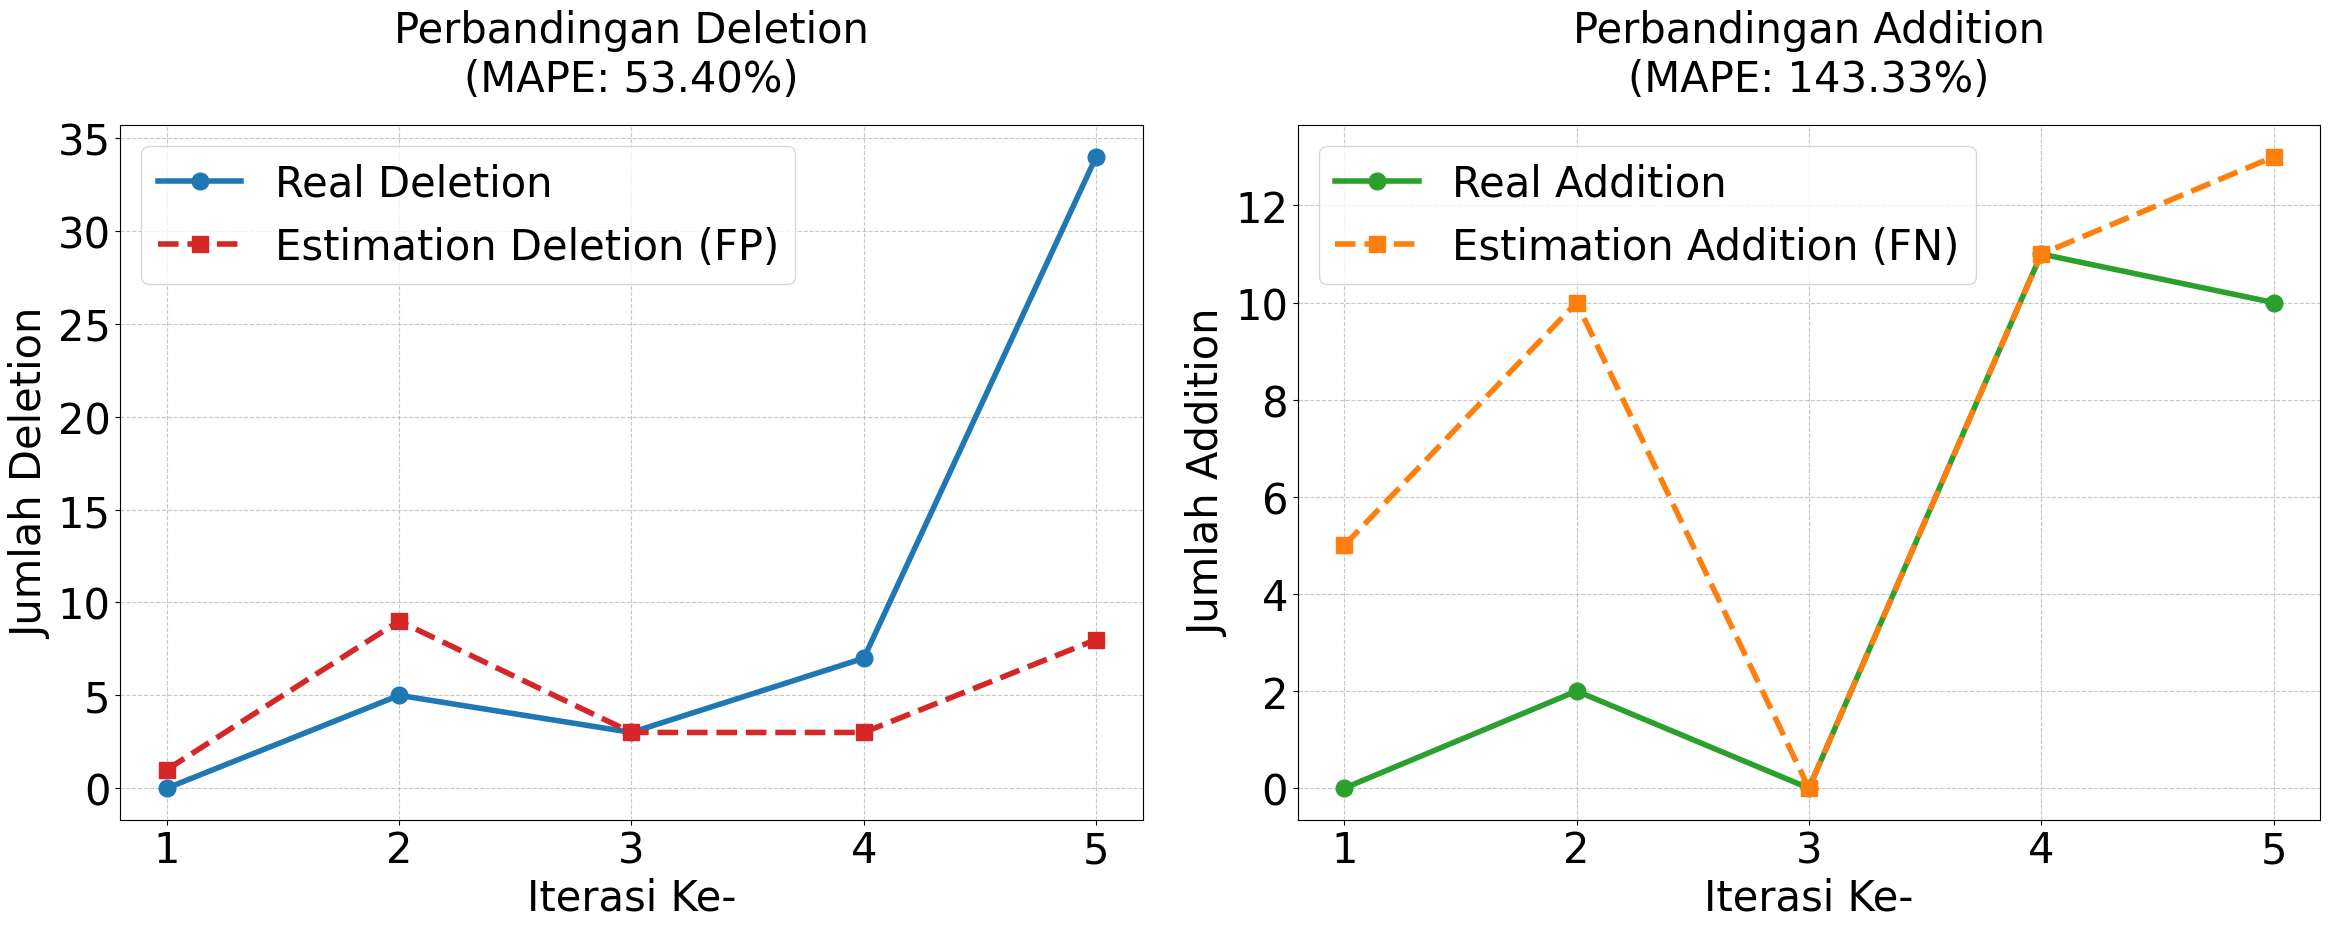

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# 1. KONFIGURASI PATH & FONT
# ==========================================
METRICS_FILE = r"C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split\metrics_per_slice.csv"
EVAL_FILE = r"C:\Users\USER\Documents\a skripsi\riset\history\10-ep-5-it\evaluasi_summary\otomatisasi_eval.csv"
FONTSIZE = 30

# Mengatur font secara global
plt.rcParams.update({'font.size': FONTSIZE})

def hitung_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Menghindari pembagian dengan nol: ganti 0 dengan angka sangat kecil (1e-10)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def buat_grafik_perbandingan_gabung():
    # Cek apakah file ada
    if not os.path.exists(METRICS_FILE) or not os.path.exists(EVAL_FILE):
        print(f"Error: Pastikan file CSV tersedia di path yang ditentukan.")
        return

    # 2. MEMBACA DATA
    df_metrics = pd.read_csv(METRICS_FILE)
    df_eval = pd.read_csv(EVAL_FILE)

    # 3. MENGGABUNGKAN DATA
    df = pd.merge(
        df_metrics[['iteration', 'FP', 'FN']], 
        df_eval[['iteration', 'ril_deletion', 'ril_addition']], 
        on='iteration'
    ).sort_values('iteration')

    mape_del = hitung_mape(df['ril_deletion'], df['FP'])
    mape_add = hitung_mape(df['ril_addition'], df['FN'])

    # 4. MEMBUAT FIGURE DENGAN 2 SUBPLOT (1 BARIS, 2 KOLOM)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

    # --- GRAFIK KIRI (DELETION) ---
    axes[0].plot(df['iteration'], df['ril_deletion'], 
                 marker='o', markersize=12, linewidth=4, 
                 label='Real Deletion', color='#1f77b4')
    axes[0].plot(df['iteration'], df['FP'], 
                 marker='s', markersize=12, linewidth=4, linestyle='--', 
                 label='Estimation Deletion (FP)', color='#d62728')
    
    # axes[0].set_title('Perbandingan Deletion', fontsize=FONTSIZE + 6, pad=20)
    axes[0].set_title(f'Perbandingan Deletion\n(MAPE: {mape_del:.2f}%)', fontsize=FONTSIZE, pad=25)
    axes[0].set_xlabel('Iterasi Ke-', fontsize=FONTSIZE)
    axes[0].set_ylabel('Jumlah Deletion', fontsize=FONTSIZE)
    axes[0].set_xticks(df['iteration'])
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(fontsize=FONTSIZE)

    # --- GRAFIK KANAN (ADDITION) ---
    axes[1].plot(df['iteration'], df['ril_addition'], 
                 marker='o', markersize=12, linewidth=4, 
                 label='Real Addition', color='#2ca02c')
    axes[1].plot(df['iteration'], df['FN'], 
                 marker='s', markersize=12, linewidth=4, linestyle='--', 
                 label='Estimation Addition (FN)', color='#ff7f0e')

    axes[1].set_title('Perbandingan Addition', fontsize=FONTSIZE + 6, pad=20)
    axes[1].set_title(f'Perbandingan Addition\n(MAPE: {mape_add:.2f}%)', fontsize=FONTSIZE, pad=25)
    axes[1].set_xlabel('Iterasi Ke-', fontsize=FONTSIZE)
    axes[1].set_ylabel('Jumlah Addition', fontsize=FONTSIZE)
    axes[1].set_xticks(df['iteration'])
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(fontsize=FONTSIZE)

    # 5. PENYESUAIAN TAMPILAN & SIMPAN
    plt.tight_layout()
    
    # Pastikan folder tujuan ada
    output_path = r"C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split\grafik_perbandingan_combined.png"
    plt.savefig(output_path, dpi=300)
    
    print(f"✅ Grafik gabungan berhasil disimpan di: {output_path}")
    plt.show()

if __name__ == "__main__":
    buat_grafik_perbandingan_gabung()

✅ Grafik gabungan berhasil disimpan di: C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split\grafik_perbandingan_combined-r.png


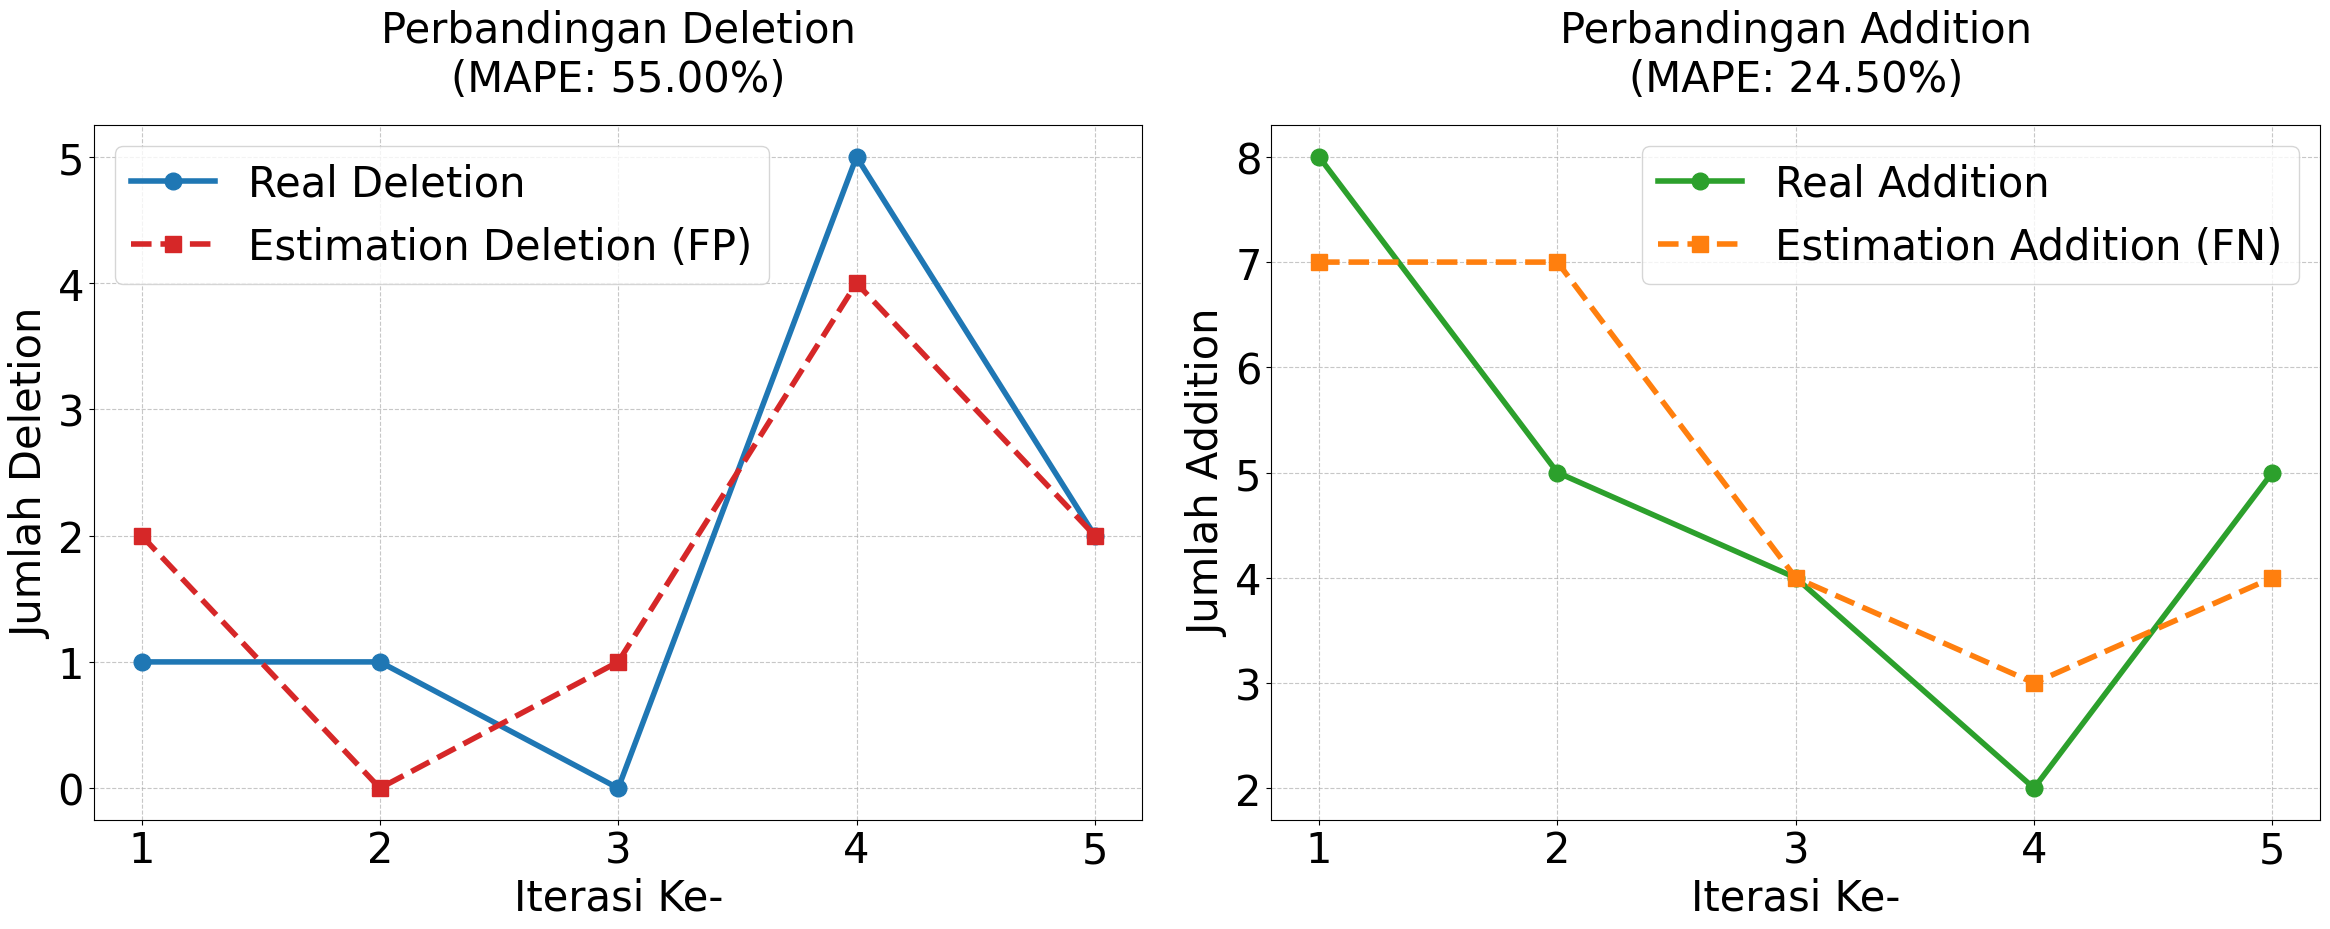

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ==========================================
# 1. KONFIGURASI PATH & FONT
# ==========================================
METRICS_FILE = r"C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split_r2\metrics_per_slice.csv"
EVAL_FILE = r"D:\10-ep-5-it-r\evaluasi_summary\otomatisasi_eval.csv"
FONTSIZE = 30

# Mengatur font secara global
plt.rcParams.update({'font.size': FONTSIZE})
def hitung_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Menghindari pembagian dengan nol: ganti 0 dengan angka sangat kecil (1e-10)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def buat_grafik_perbandingan_gabung():
    # Cek apakah file ada
    if not os.path.exists(METRICS_FILE) or not os.path.exists(EVAL_FILE):
        print(f"Error: Pastikan file CSV tersedia di path yang ditentukan.")
        return

    # 2. MEMBACA DATA
    df_metrics = pd.read_csv(METRICS_FILE)
    df_eval = pd.read_csv(EVAL_FILE)

    # 3. MENGGABUNGKAN DATA
    df = pd.merge(
        df_metrics[['iteration', 'FP', 'FN']], 
        df_eval[['iteration', 'ril_deletion', 'ril_addition']], 
        on='iteration'
    ).sort_values('iteration')

    # --- HITUNG MAPE ---
    mape_del = hitung_mape(df['ril_deletion'], df['FP'])
    mape_add = hitung_mape(df['ril_addition'], df['FN'])

    # 4. MEMBUAT FIGURE DENGAN 2 SUBPLOT (1 BARIS, 2 KOLOM)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

    # --- GRAFIK KIRI (DELETION) ---
    axes[0].plot(df['iteration'], df['ril_deletion'], 
                 marker='o', markersize=12, linewidth=4, 
                 label='Real Deletion', color='#1f77b4')
    axes[0].plot(df['iteration'], df['FP'], 
                 marker='s', markersize=12, linewidth=4, linestyle='--', 
                 label='Estimation Deletion (FP)', color='#d62728')
    
    # axes[0].set_title('Perbandingan Deletion', fontsize=FONTSIZE + 6, pad=20)
    axes[0].set_title(f'Perbandingan Deletion\n(MAPE: {mape_del:.2f}%)', fontsize=FONTSIZE, pad=25)
    axes[0].set_xlabel('Iterasi Ke-', fontsize=FONTSIZE)
    axes[0].set_ylabel('Jumlah Deletion', fontsize=FONTSIZE)
    axes[0].set_xticks(df['iteration'])
    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].legend(fontsize=FONTSIZE)

    # --- GRAFIK KANAN (ADDITION) ---
    axes[1].plot(df['iteration'], df['ril_addition'], 
                 marker='o', markersize=12, linewidth=4, 
                 label='Real Addition', color='#2ca02c')
    axes[1].plot(df['iteration'], df['FN'], 
                 marker='s', markersize=12, linewidth=4, linestyle='--', 
                 label='Estimation Addition (FN)', color='#ff7f0e')

    # axes[1].set_title('Perbandingan Addition', fontsize=FONTSIZE + 6, pad=20)
    axes[1].set_title(f'Perbandingan Addition\n(MAPE: {mape_add:.2f}%)', fontsize=FONTSIZE, pad=25)
    axes[1].set_xlabel('Iterasi Ke-', fontsize=FONTSIZE)
    axes[1].set_ylabel('Jumlah Addition', fontsize=FONTSIZE)
    axes[1].set_xticks(df['iteration'])
    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].legend(fontsize=FONTSIZE)

    # 5. PENYESUAIAN TAMPILAN & SIMPAN
    plt.tight_layout()
    
    # Pastikan folder tujuan ada
    output_path = r"C:\Users\USER\Documents\a skripsi\workv1\app\notebook_penelitian\hasil_evaluasi_split\grafik_perbandingan_combined-r.png"
    plt.savefig(output_path, dpi=300)
    
    print(f"✅ Grafik gabungan berhasil disimpan di: {output_path}")
    plt.show()

if __name__ == "__main__":
    buat_grafik_perbandingan_gabung()